In [122]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


from data_loading.extract_indices import extract_trajectory_indices
from data_loading.load_data import load_dataset


# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 임의의 하이퍼파라미터 설정
latent_dim = 64  # 인코더에서 나오는 잠재 공간 차원
batch_size = 32
num_epochs = 100  # 학습 에폭 수
env_name = "box-close-v2"
# env_name = "sweep-v2"
# env_name = "button-press-topdown-v2"
# env_name = "dial-turn-v2"
exp_name = "augmentor-test"
pair_algo = "ternary-500"
TRAJECTORY_LENGTH=25


dataset = load_dataset(env_name=env_name)
indices = extract_trajectory_indices(dataset)
cum_sum = np.cumsum(dataset["rewards"])
average_reward = np.mean(dataset["rewards"])
average_success = np.mean(dataset["success"])

success_traj = 0

for i, e in indices:
    success = dataset["success"][i:e].sum()
    if success > 0:
        success_traj += 1



print ("ENV", env_name)
print("average reward", average_reward)
print("average success", average_success)
print("success traj ratio", success_traj / len(indices))


trajectory counts 4800
ENV box-close-v2
average reward 1.0545151
average success 0.039954583333333335
success traj ratio 0.08041666666666666


In [123]:
def fill_feedback_from_raw_dataset(average_reward, cumulative_rewards, pairs):
    """
    Fill feedback in dataset using cumulative rewards and calculate mu values.
    """

    feedbacks = []

    for s0, s1 in pairs:
        sum_of_rewards_0 = cumulative_rewards[s0[1] - 1] - (
            cumulative_rewards[s0[0] - 1] if s0[0] > 0 else 0
        )
        sum_of_rewards_1 = cumulative_rewards[s1[1] - 1] - (
            cumulative_rewards[s1[0] - 1] if s1[0] > 0 else 0
        )

        if (
            np.abs(sum_of_rewards_0 - sum_of_rewards_1)
            < average_reward * TRAJECTORY_LENGTH * 0.1
        ):
            mu = 0.5
        else:
            mu = 0 if sum_of_rewards_0 > sum_of_rewards_1 else 1

        feedbacks.append((s0, s1, mu))

    return feedbacks


In [124]:
from data_generation.utils import generate_pairs_from_indices, save_feedbacks_npz



# ✅ 학습 데이터 생성 (500개)
train_pairs = generate_pairs_from_indices(
    trajectories=indices,
    pair_count=1000,
    trajectory_length=25,
)

# ✅ 테스트 데이터 생성 (10,000개)
test_pairs = generate_pairs_from_indices(
    trajectories=indices,
    pair_count=100000,
    trajectory_length=25,
)

train_feedbacks = fill_feedback_from_raw_dataset(
    average_reward=average_reward,
    cumulative_rewards=cum_sum,
    pairs=train_pairs,
)

test_feedbacks = fill_feedback_from_raw_dataset(
    average_reward=average_reward,
    cumulative_rewards=cum_sum,
    pairs=test_pairs,
)

train_feedbacks_split = []
for feedback in train_feedbacks:
    s0, s1, mu = feedback

    possible_s0 = []
    possible_s1 = []

    possible_s0.append(s0)
    possible_s1.append(s1)

    if s0[0] % 500 != 0:
        possible_s0.append((s0[0] - 1, s0[1] - 1))
    
    if s0[1] % 500 != 499:
        possible_s0.append((s0[0] + 1, s0[1] + 1))

    if s1[0] % 500 != 0:
        possible_s1.append((s1[0] - 1, s1[1] - 1))

    if s1[1] % 500 != 499:
        possible_s1.append((s1[0] + 1, s1[1] + 1))

    for s0 in possible_s0:
        for s1 in possible_s1:
            train_feedbacks_split.append((s0, s1, mu))
            train_feedbacks_split.append((s1, s0, 1 - mu))
        
print(len(train_feedbacks_split))

train_split_pairs = [(s0, s1) for s0, s1, _ in train_feedbacks_split]
train_split_raw_feedbacks = fill_feedback_from_raw_dataset(
    average_reward=average_reward,
    cumulative_rewards=cum_sum,
    pairs=train_split_pairs,
)

train_split_correct = 0
for i, (s0, s1, mu) in enumerate(train_feedbacks_split):
    if train_split_raw_feedbacks[i][2] == mu:
        train_split_correct += 1

print("train split accuracy", train_split_correct / len(train_feedbacks_split))


# 학습 데이터
save_feedbacks_npz(
    env_name=env_name,
    exp_name=exp_name,
    pair_type="train",
    pair_name=pair_algo,
    feedbacks=train_feedbacks,
)

save_feedbacks_npz(
    env_name=env_name,
    exp_name=exp_name,
    pair_type="test",
    pair_name=pair_algo,
    feedbacks=test_feedbacks,
)




17964
train split accuracy 0.9946559786239145
Saved feedbacks at pair/box-close-v2/augmentor-test/train/ternary-500.npz
Saved feedbacks at pair/box-close-v2/augmentor-test/test/ternary-500.npz


In [125]:
from data_generation.classifier.trajectory_pair_classifier import train_trajectory_pair_classifier


train_trajectory_pair_classifier(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo,
    batch_size=batch_size,
    num_epochs=num_epochs,
    device=device,
)

Loaded pair/box-close-v2/augmentor-test/train/ternary-500.npz dataset


/Users/lockcept/osilab/SPA/src/data_generation/classifier/trajectory_pair_classifier.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(mo

Processed data with 1000 samples
✅ Loaded existing model from model/box-close-v2/augmentor-test/classifier/ternary-500/trajectory-pair-classifier.pth


Epoch 100/100: 100%|██████████| 32/32 [00:00<00:00, 988.89it/s]


✅ Model saved at model/box-close-v2/augmentor-test/classifier/ternary-500/trajectory-pair-classifier.pth


In [126]:
from data_generation.classifier.trajectory_pair_classifier import TrajectoryPairClassifier
from data_loading.preference_dataloader import get_dataloader
from utils.path import get_trajectory_pair_classifier_path

model_path = get_trajectory_pair_classifier_path(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo,
)

classifier = TrajectoryPairClassifier(input_dim=43*25).to(device)
classifier.load_state_dict(torch.load(model_path))
classifier.eval()

test_loader = get_dataloader(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="test",
        pair_algo=pair_algo,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
    )



/var/folders/j2/qf7z8yf14kx2r606tsl_zhtm0000gn/T/ipykernel_13458/627051988.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(model_p

Loaded pair/box-close-v2/augmentor-test/test/ternary-500.npz dataset
Processed data with 100000 samples


Evaluating Model:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating Model: 100%|██████████| 3125/3125 [00:02<00:00, 1422.25it/s]


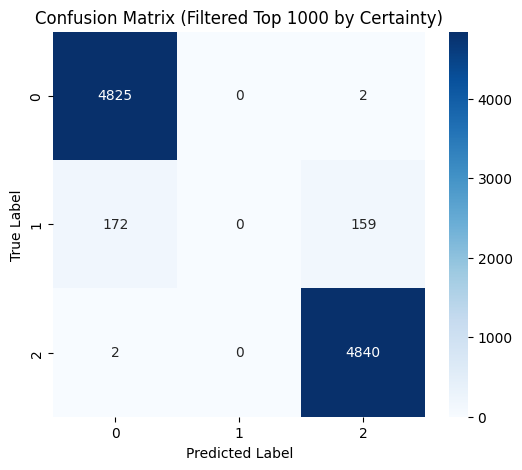

✅ Accuracy (Filtered Top 1000 by Certainty): 96.65%


In [131]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# ✅ 원본 mu 및 예측 mu 저장
original_mu_list = []
predicted_mu_list = []

# ✅ Flip된 mu 및 예측 mu 저장
flipped_predicted_mu_list = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating Model"):
        (
            s0_obs_batch,
            s0_act_batch,
            s1_obs_batch,
            s1_act_batch,
            mu_batch,
            _,
            _,
        ) = [x.to(device) for x in batch]

        batch_dim = s0_obs_batch.shape[0]

        # ✅ 원래 순서
        s0_batch = torch.cat((s0_obs_batch, s0_act_batch), dim=-1).reshape(batch_dim, -1)
        s1_batch = torch.cat((s1_obs_batch, s1_act_batch), dim=-1).reshape(batch_dim, -1)
        batch = torch.cat((s0_batch, s1_batch), dim=-1)

        output = classifier(batch)
        predicted_mu = torch.sigmoid(output[:, 1])  # Class 1의 확률값

        # ✅ Flip된 순서 (s1, s0로 바꿈)
        flipped_batch = torch.cat((s1_batch, s0_batch), dim=-1)
        flipped_output = classifier(flipped_batch)
        flipped_predicted_mu = torch.sigmoid(flipped_output[:, 1])

        # ✅ 데이터 저장
        original_mu_list.append(mu_batch.cpu().numpy())
        predicted_mu_list.append(predicted_mu.cpu().numpy())
        flipped_predicted_mu_list.append(flipped_predicted_mu.cpu().numpy())

# ✅ 리스트를 Numpy 배열로 변환
original_mu_array = np.concatenate(original_mu_list, axis=0)
predicted_mu_array = np.concatenate(predicted_mu_list, axis=0)
flipped_predicted_mu_array = np.concatenate(flipped_predicted_mu_list, axis=0)

# ✅ Uncertainty 계산 (mu + flipped_mu가 1에 가까울수록 확신 높음)
certainty_scores = np.abs((predicted_mu_array + flipped_predicted_mu_array) - 1)

# ✅ 상위 1,0000개 샘플 선택 (uncertainty가 낮은 순서대로 정렬)
top_1000_indices = np.argsort(certainty_scores)[:10000]

# ✅ 필터링된 데이터셋 생성
filtered_original = original_mu_array[top_1000_indices]
filtered_predicted = predicted_mu_array[top_1000_indices]

# ✅ mu 값을 3단계로 범주화 (중립값은 Class 2)
def categorize_mu(mu_array):
    mu_classes = np.full_like(mu_array, 1, dtype=int)  # 기본값 1 (중립)
    mu_classes[mu_array < 1/3] = 0  # Class 0
    mu_classes[mu_array > 2/3] = 2  # Class 1
    return mu_classes

filtered_original_classes = categorize_mu(filtered_original)
filtered_predicted_classes = categorize_mu(filtered_predicted)

# ✅ 3×3 Confusion Matrix 계산
cm = confusion_matrix(filtered_original_classes, filtered_predicted_classes, labels=[0, 1, 2])

# ✅ Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Filtered Top 1000 by Certainty)")
plt.show()

# ✅ 일치하는 비율 (Accuracy) 계산
correct_predictions = np.trace(cm)  # 대각선 합 (TP + TP + TP)
total_predictions = np.sum(cm)  # 전체 샘플 수
accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

# ✅ 결과 출력
print(f"✅ Accuracy (Filtered Top 1000 by Certainty): {accuracy:.2f}%")